In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

DATA_DIR = './dataset_2'
TEST_DIR = './test'
IMG_SIZE = (128, 128)


🔍 Performing EDA...
📦 Total Images: 480
Images per class:
  glioma: 120
  meningioma: 120
  notumor: 120
  pituitary: 120


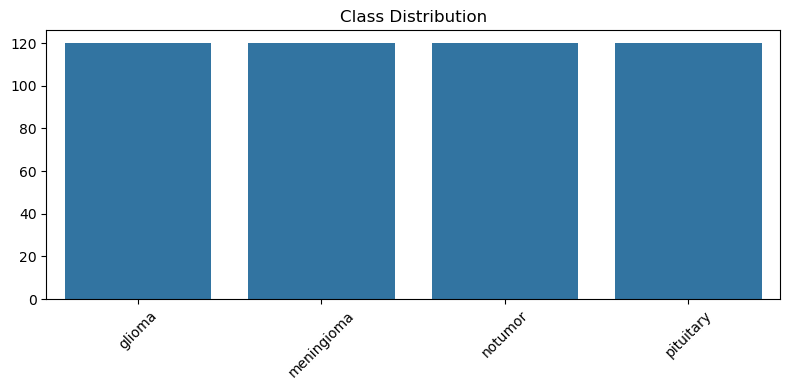

Unique image dimensions: {(233, 210), (420, 280), (244, 274), (491, 624), (411, 396), (206, 244), (503, 369), (393, 400), (200, 252), (201, 251), (318, 354), (485, 510), (420, 264), (330, 355), (235, 227), (441, 442), (200, 236), (470, 432), (356, 474), (374, 370), (220, 275), (150, 198), (227, 262), (323, 342), (235, 229), (590, 332), (630, 423), (207, 243), (267, 328), (502, 502), (234, 224), (450, 504), (540, 568), (550, 664), (456, 501), (174, 230), (232, 217), (224, 286), (315, 315), (236, 260), (236, 269), (626, 686), (276, 326), (256, 256), (201, 250), (221, 228), (192, 192), (312, 401), (236, 262), (1024, 1024), (236, 280), (225, 225), (200, 235), (366, 395), (218, 231), (680, 680), (474, 474), (717, 717), (591, 650), (350, 350), (238, 212), (442, 442), (173, 201), (341, 377), (926, 649), (236, 257), (228, 228), (300, 168), (211, 239), (416, 489), (230, 274), (622, 777), (216, 302), (236, 250), (210, 240), (228, 221), (236, 213), (200, 223), (234, 225), (314, 260), (227, 222), 

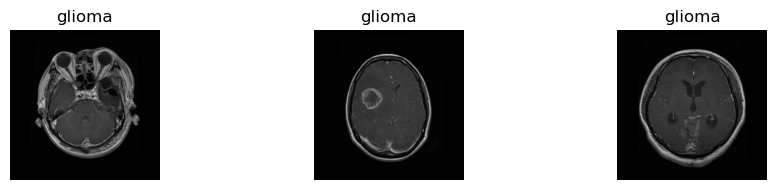

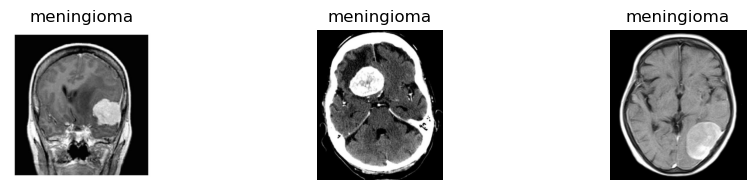

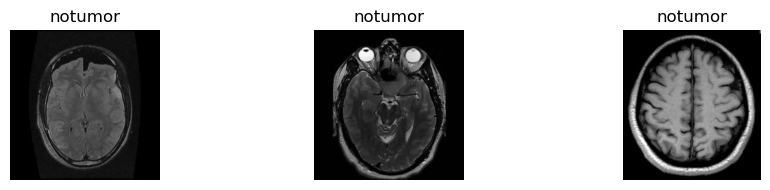

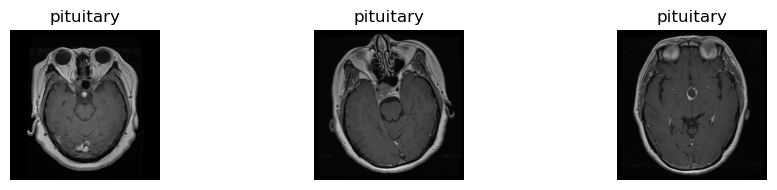

✅ No corrupted images found.


In [16]:
def perform_eda(data_dir):
    import seaborn as sns
    from collections import defaultdict

    print("🔍 Performing EDA...")
    image_count = 0
    class_image_counts = {}
    image_shapes = []
    corrupted_images = []
    sample_images = defaultdict(list)

    class_names = sorted(os.listdir(data_dir))
    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        image_files = os.listdir(class_path)
        class_image_counts[class_name] = len(image_files)
        image_count += len(image_files)
        for i, img_name in enumerate(image_files):
            img_path = os.path.join(class_path, img_name)
            try:
                img = tf.keras.preprocessing.image.load_img(img_path)
                image_shapes.append(img.size)
                if i < 3:
                    sample_images[class_name].append(img)
            except Exception as e:
                print(f"⚠️ Error loading {img_path}: {e}")
                corrupted_images.append(img_path)

    print(f"📦 Total Images: {image_count}")
    print("Images per class:")
    for k, v in class_image_counts.items():
        print(f"  {k}: {v}")

    # Bar Plot
    plt.figure(figsize=(8, 4))
    sns.barplot(x=list(class_image_counts.keys()), y=list(class_image_counts.values()))
    plt.title("Class Distribution")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Dimensions
    print(f"Unique image dimensions: {set(image_shapes)}")

    # Sample images
    for class_name, imgs in sample_images.items():
        plt.figure(figsize=(10, 2))
        for i, img in enumerate(imgs):
            plt.subplot(1, 3, i+1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis("off")
        plt.tight_layout()
        plt.show()

    if corrupted_images:
        print(f"❌ Found {len(corrupted_images)} corrupted images.")
    else:
        print("✅ No corrupted images found.")

perform_eda(DATA_DIR)


In [17]:
def extract_features_and_labels(data_dir):
    features, labels = [], []
    base_model = MobileNetV2(include_top=False, weights='imagenet', pooling='avg', input_shape=(128, 128, 3))

    class_names = sorted(os.listdir(data_dir))
    for label_idx, class_name in enumerate(class_names):
        class_path = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
            img_array = img_to_array(img)
            img_array = preprocess_input(img_array)
            img_array = np.expand_dims(img_array, axis=0)
            feature = base_model.predict(img_array, verbose=0)
            features.append(feature.squeeze())
            labels.append(label_idx)
    return np.array(features), np.array(labels), class_names

X, y, class_names = extract_features_and_labels(DATA_DIR)
print(f"✅ Extracted features: {X.shape}, Labels: {y.shape}, Classes: {class_names}")


✅ Extracted features: (480, 1280), Labels: (480,), Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [18]:
# Function to train binary classifiers for each class
def train_binary_classifiers(X, y, class_names):
    classifiers = {}
    scalers = {}

    for idx, class_name in enumerate(class_names):
        print(f"\n🧠 Training SVM for '{class_name}'")
        y_binary = (y == idx).astype(int)
        X_train, X_val, y_train, y_val = train_test_split(X, y_binary, test_size=0.2, stratify=y_binary, random_state=42)

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        clf = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
        clf.fit(X_train_scaled, y_train)

        y_pred = clf.predict(X_val_scaled)

        print(classification_report(y_val, y_pred, target_names=['Not '+class_name, class_name]))
        print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

        classifiers[class_name] = clf
        scalers[class_name] = scaler
        
    return classifiers, scalers

classifiers, scalers = train_binary_classifiers(X, y, class_names)



🧠 Training SVM for 'glioma'
              precision    recall  f1-score   support

  Not glioma       0.93      0.99      0.96        72
      glioma       0.95      0.79      0.86        24

    accuracy                           0.94        96
   macro avg       0.94      0.89      0.91        96
weighted avg       0.94      0.94      0.94        96

Confusion Matrix:
 [[71  1]
 [ 5 19]]

🧠 Training SVM for 'meningioma'
                precision    recall  f1-score   support

Not meningioma       0.88      0.99      0.93        72
    meningioma       0.93      0.58      0.72        24

      accuracy                           0.89        96
     macro avg       0.90      0.78      0.82        96
  weighted avg       0.89      0.89      0.88        96

Confusion Matrix:
 [[71  1]
 [10 14]]

🧠 Training SVM for 'notumor'
              precision    recall  f1-score   support

 Not notumor       0.91      0.99      0.95        72
     notumor       0.94      0.71      0.81        24

  

In [19]:
# Function to train binary classifiers for each class with fine tuning
def train_binary_classifiers_with_tuning(X, y, class_names):
    classifiers = {}
    scalers = {}

    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    }

    for idx, class_name in enumerate(class_names):
        print(f"\n🧠 Training SVM for '{class_name}'")
        y_binary = (y == idx).astype(int)
        X_train, X_val, y_train, y_val = train_test_split(X, y_binary, test_size=0.2, stratify=y_binary, random_state=42)

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        clf = SVC(probability=True)
        grid = GridSearchCV(clf, param_grid, cv=3, scoring='f1', n_jobs=-1)
        grid.fit(X_train_scaled, y_train)

        best_clf = grid.best_estimator_
        y_pred = best_clf.predict(X_val_scaled)

        print(f"Best params: {grid.best_params_}")
        print(classification_report(y_val, y_pred, target_names=['Not '+class_name, class_name]))
        print(confusion_matrix(y_val, y_pred))

        classifiers[class_name] = best_clf
        scalers[class_name] = scaler

    return classifiers, scalers

classifiers, scalers = train_binary_classifiers_with_tuning(X, y, class_names)



🧠 Training SVM for 'glioma'
Best params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
              precision    recall  f1-score   support

  Not glioma       0.96      0.93      0.94        72
      glioma       0.81      0.88      0.84        24

    accuracy                           0.92        96
   macro avg       0.88      0.90      0.89        96
weighted avg       0.92      0.92      0.92        96

[[67  5]
 [ 3 21]]

🧠 Training SVM for 'meningioma'
Best params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
                precision    recall  f1-score   support

Not meningioma       0.93      0.94      0.94        72
    meningioma       0.83      0.79      0.81        24

      accuracy                           0.91        96
     macro avg       0.88      0.87      0.87        96
  weighted avg       0.91      0.91      0.91        96

[[68  4]
 [ 5 19]]

🧠 Training SVM for 'notumor'
Best params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
              prec

In [20]:
def extract_test_features(test_dir, class_names):
    features = []
    labels = []
    base_model = MobileNetV2(include_top=False, weights='imagenet', pooling='avg', input_shape=(128, 128, 3))

    for label_idx, class_name in enumerate(class_names):
        class_path = os.path.join(test_dir, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
            img_array = img_to_array(img)
            img_array = preprocess_input(img_array)
            img_array = np.expand_dims(img_array, axis=0)
            feature = base_model.predict(img_array, verbose=0)
            features.append(feature.squeeze())
            labels.append(label_idx)

    return np.array(features), np.array(labels)

X_test, y_test = extract_test_features(TEST_DIR, class_names)
print(f"✅ Test features: {X_test.shape}, Labels: {y_test.shape}")


✅ Test features: (480, 1280), Labels: (480,)


In [21]:
def evaluate_one_vs_rest(classifiers, scalers, X_test, y_test, class_names):
    print("\n📊 Evaluating on test dataset...")
    n_samples, n_classes = X_test.shape[0], len(class_names)
    probs = np.zeros((n_samples, n_classes))

    for idx, class_name in enumerate(class_names):
        scaler = scalers[class_name]
        clf = classifiers[class_name]
        probs[:, idx] = clf.predict_proba(scaler.transform(X_test))[:, 1]

    y_pred = np.argmax(probs, axis=1)
    print(classification_report(y_test, y_pred, target_names=class_names))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


In [22]:
def evaluate_one_vs_rest(classifiers, scalers, X_test, y_test, class_names):
    n_samples = X_test.shape[0]
    n_classes = len(class_names)
    probs = np.zeros((n_samples, n_classes))

    for idx, class_name in enumerate(class_names):
        scaler = scalers[class_name]
        clf = classifiers[class_name]
        probs[:, idx] = clf.predict_proba(scaler.transform(X_test))[:, 1]

    y_pred = np.argmax(probs, axis=1)

    print("\n📋 Final Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

evaluate_one_vs_rest(classifiers, scalers, X_test, y_test, class_names)



📋 Final Classification Report:
              precision    recall  f1-score   support

      glioma       0.90      0.93      0.91       120
  meningioma       0.82      0.72      0.77       120
     notumor       0.85      0.91      0.88       120
   pituitary       0.92      0.94      0.93       120

    accuracy                           0.88       480
   macro avg       0.87      0.88      0.87       480
weighted avg       0.87      0.88      0.87       480

Confusion Matrix:
 [[111   5   1   3]
 [ 10  87  17   6]
 [  1   9 109   1]
 [  1   5   1 113]]


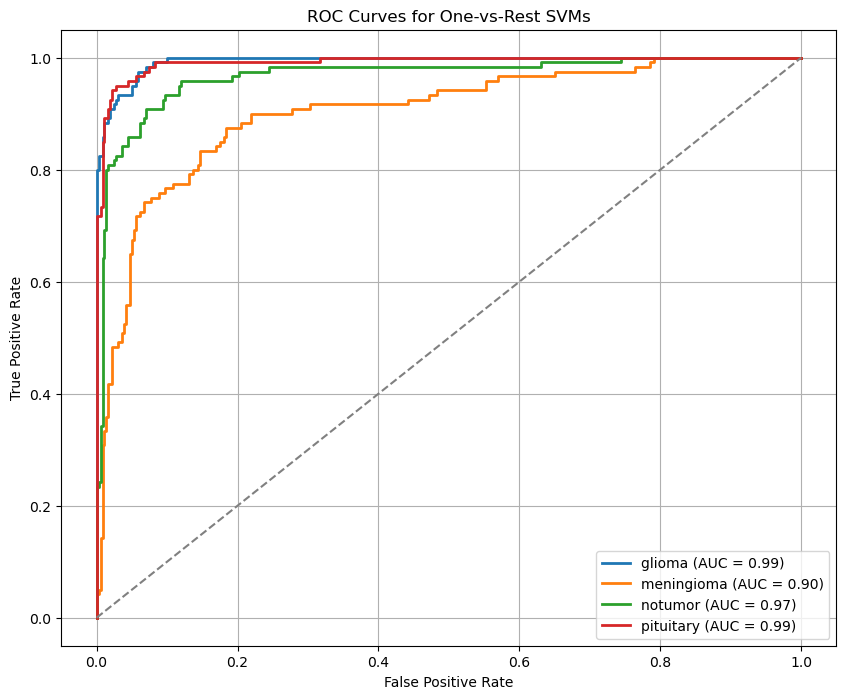

In [23]:
def plot_roc_curves(classifiers, scalers, X_test, y_test, class_names):
    plt.figure(figsize=(10, 8))

    for idx, class_name in enumerate(class_names):
        y_true = (y_test == idx).astype(int)
        y_scores = classifiers[class_name].predict_proba(scalers[class_name].transform(X_test))[:, 1]
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{class_name} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves for One-vs-Rest SVMs")
    plt.legend()
    plt.grid()
    plt.show()

plot_roc_curves(classifiers, scalers, X_test, y_test, class_names)
